In [32]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [33]:
train_path = 'speech-based-classification-layer-10/train.csv'
valid_path = 'speech-based-classification-layer-10/valid.csv'
test_path = 'speech-based-classification-layer-10/test.csv'
train = pd.read_csv(train_path)
valid = pd.read_csv(valid_path)
test = pd.read_csv(test_path)
original_train = train.copy()
original_valid = train.copy()
original_test = test.copy()

In [34]:
train.isnull().sum()

feature_1        0
feature_2        0
feature_3        0
feature_4        0
feature_5        0
              ... 
feature_768      0
label_1          0
label_2        480
label_3          0
label_4          0
Length: 772, dtype: int64

In [35]:
valid.isnull().sum()

feature_1       0
feature_2       0
feature_3       0
feature_4       0
feature_5       0
               ..
feature_768     0
label_1         0
label_2        14
label_3         0
label_4         0
Length: 772, dtype: int64

In [36]:
train_features = train.iloc[:, :768]
train_label_1 = train.iloc[:, 768]

valid_features = valid.iloc[:, :768]
valid_label_1 = valid.iloc[:, 768]

test_features = test.iloc[:, 1:]

Class Distribution Plot

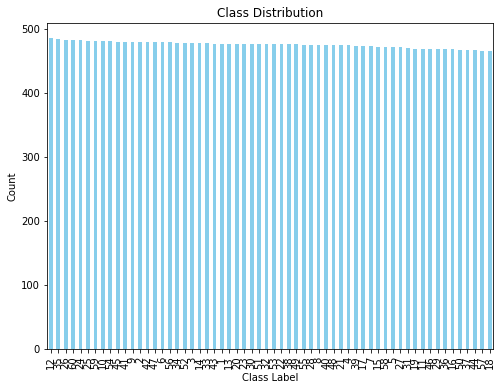

In [38]:
class_counts = train_label_1.value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution')


plt.show()

From SVM and Random Forest classifiers choosing the best classification model
1. Stratified K Fold model is used for cross validation
2. Default parameters of classifcation models are used
3. Since classes are balanced accuracy score is used for the evaluation

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



classifiers = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
}


best_model = None
best_accuracy = 0.0


n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

for name, clf in classifiers.items():
    total_accuracy = 0.0

    for train_index, test_index in skf.split(train_features, train_label_1):
        X_train, X_test = train_features.iloc[train_index], train_features.iloc[test_index]
        y_train, y_test = train_label_1[train_index], train_label_1[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        total_accuracy += accuracy

    average_accuracy = total_accuracy / n_splits
    print(f"{name} - Average Accuracy: {average_accuracy}")


    if average_accuracy > best_accuracy:
        best_model = clf
        best_accuracy = average_accuracy

print(f"Best Model: {type(best_model).__name__}")

PCA Transformation 

In [40]:
from sklearn.decomposition import PCA

def performPca(train_input, valid_input,test_input, n_components):
    pca = PCA(n_components=n_components , svd_solver='full')
    train_reduced = pca.fit_transform(train_input)
    valid_reduced = pca.transform(valid_input)
    test_reduced = pca.transform(test_input)
    train_reduced_df = pd.DataFrame(train_reduced, columns=[f"new_feature_{i+1}" for i in range(train_reduced.shape[1])])
    valid_reduced_df = pd.DataFrame(valid_reduced, columns=[f"new_feature_{i+1}" for i in range(valid_reduced.shape[1])])
    test_reduced_df = pd.DataFrame(test_reduced, columns=[f"new_feature_{i+1}" for i in range(test_reduced.shape[1])])


    return train_reduced_df, valid_reduced_df,test_reduced_df

In [42]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler()
scaled_train_features = transformer.fit_transform(train_features)
scaled_valid_features = transformer.fit_transform(valid_features)
scaled_test_features = transformer.fit_transform(test_features)

In [55]:
train_reduced_df, valid_reduced_df,test_reduced_df = performPca(scaled_train_features, scaled_valid_features, scaled_test_features, 0.99)

In [57]:
model = SVC()
model.fit(train_reduced_df, train_label_1)
y_pred = model.predict(valid_reduced_df)
accuracy = accuracy_score(valid_label_1, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9533333333333334


In [58]:
# 0.99 ----- > 0.9533333333333334
# mle -------> 0.9533333333333334    767
# 300 -------> 0.9533333333333334    300
test_pred = model.predict(test_reduced_df)

In [59]:
#Write to file
test_pred_df = pd.DataFrame(test_pred, columns=['label_1'])
test_pred_df.to_csv('predictions/label_1.csv', index=False)

# Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# defining parameter range
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf' , 'linear', 'poly']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(train_reduced_df, train_label_1)

In [60]:
from sklearn.svm import SVC

fin_model = SVC(C= 0.1, gamma = 1, kernel = 'linear')
fin_model.fit(train_reduced_df, train_label_1)
fin_y_pred = fin_model.predict(valid_reduced_df)
accuracy = accuracy_score(valid_label_1, fin_y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.964


In [61]:
fin_test_pred = fin_model.predict(test_reduced_df)

In [62]:
#Write to file
fin_test_pred_df = pd.DataFrame(fin_test_pred, columns=['label_1'])
fin_test_pred_df.to_csv('predictions/label_1_1.csv', index=False)